<a href="https://colab.research.google.com/github/jangbulama/ai-workshop-1/blob/main/Week7_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Images, Normalize, and Reshape

In [ ]:
import os
import numpy as np
from PIL import Image

IMG_HEIGHT, IMG_WIDTH = 32, 32
DATASET_PATH = "/content/drive/MyDrive/Deep_Learning /Copy of devnagari digit/DevanagariHandwrittenDigitDataset/Train"

def load_images_from_folder(base_path):
    images = []
    for label in sorted(os.listdir(base_path)):
        class_path = os.path.join(base_path, label)
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                img_path = os.path.join(class_path, img_file)
                try:
                    img = Image.open(img_path).convert("L")
                    img = img.resize((IMG_WIDTH, IMG_HEIGHT))
                    img = np.array(img, dtype=np.float32) / 255.0
                    images.append(img)
                except:
                    continue
    return np.array(images)

images = load_images_from_folder(DATASET_PATH)
images = images.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1)
print("Total Images Loaded:", images.shape)


Total Images Loaded: (17040, 32, 32, 1)


Add Noise (Gaussian or Salt-Pepper)

In [ ]:
def add_gaussian_noise(imgs, noise_factor=0.5):
    noisy = imgs + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=imgs.shape)
    noisy = np.clip(noisy, 0., 1.)
    return noisy

noisy_images = add_gaussian_noise(images)
print("Noise added:", noisy_images.shape)


Noise added: (17040, 32, 32, 1)


Split into Train and Test

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, x_train_noisy, x_test_noisy = train_test_split(
    images, noisy_images, test_size=0.2, random_state=42
)

print("Train:", x_train.shape, " Test:", x_test.shape)


Train: (13632, 32, 32, 1)  Test: (3408, 32, 32, 1)


Build a 4-Layer Deep Convolutional Autoencoder

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_autoencoder():
    input_img = layers.Input(shape=(32, 32, 1))

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder

autoencoder = build_autoencoder()
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

Train the Autoencoder

In [ ]:
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test)
)


Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.4234 - val_loss: 0.1893
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1837 - val_loss: 0.1727
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1687 - val_loss: 0.1659
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1641 - val_loss: 0.1610
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1599 - val_loss: 0.1616
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1580 - val_loss: 0.1570
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1562 - val_loss: 0.1555
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1542 - val_loss: 0.1558
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1535 - val_loss: 0.1534
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1531 - val_loss: 0.1525


Visualize Clean vs Denoised Results

107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


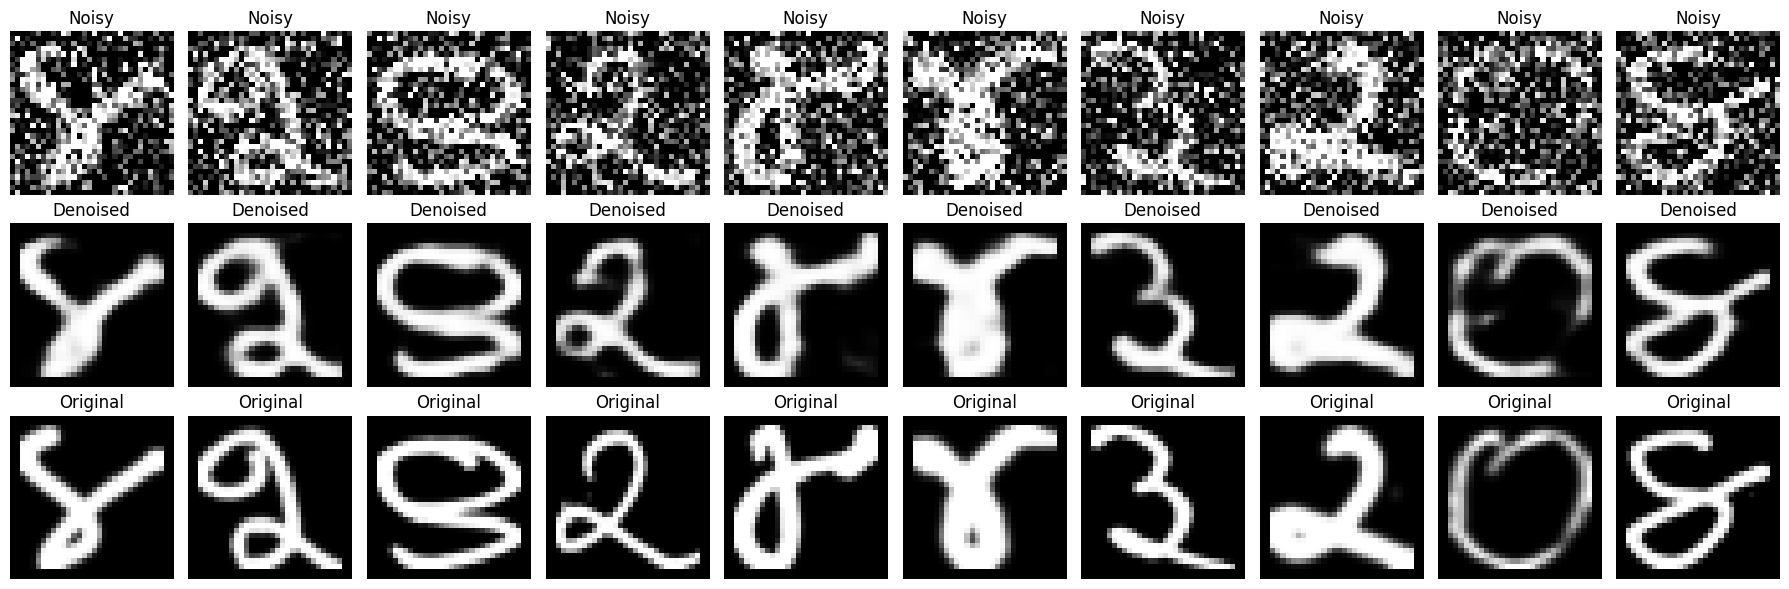

In [ ]:
import matplotlib.pyplot as plt

decoded_imgs = autoencoder.predict(x_test_noisy)

def plot_denoised(noisy, denoised, clean, n=10):
    plt.figure(figsize=(18, 6))
    for i in range(n):
        # Noisy input
        plt.subplot(3, n, i + 1)
        plt.imshow(noisy[i].reshape(32, 32), cmap='gray')
        plt.title("Noisy")
        plt.axis('off')

        # Denoised output
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised[i].reshape(32, 32), cmap='gray')
        plt.title("Denoised")
        plt.axis('off')

        # Original clean image
        plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(clean[i].reshape(32, 32), cmap='gray')
        plt.title("Original")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_denoised(x_test_noisy, decoded_imgs, x_test)
